<div style="border:2px solid Black; padding:20px;">

#Определение стоимости автомобилей#

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости.

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

# Примечания:

- Для оценки качества моделей применяйте метрику RMSE.
- Самостоятельно освойте библиотеку LightGBM и её средствами постройте модели градиентного бустинга.
- Время выполнения ячейки кода Jupyter Notebook можно получить специальной командой. Найдите её.
- Поскольку модель градиентного бустинга может обучаться долго, измените у неё только два-три параметра.
- Если перестанет работать Jupyter Notebook, удалите лишние переменные оператором del: del features_train

# Признаки:

- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

# Целевой признак:

- Price — цена (евро)

# План работы.

1. Загрузить данные и провести предобработку.
2. Выполнить сравнение моделей с использованием различных наборов гиперпараметров.
3. Выбрать лучшую модель по результатам метрики RMSE и времени обучения.
4. Оформить проект и написать выводы.

</div>

## Подготовка данных

### Анализ данных

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import time

Выгрузим данные из таблицы и изучим их.

In [ ]:
autos_data = pd.read_csv('datasets/autos.csv')
display(autos_data.info())
autos_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

None

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Оценим количество пропусков по каждому критерию.

In [ ]:
autos_data.isna().mean()

DateCrawled          0.000000
Price                0.000000
VehicleType          0.105794
RegistrationYear     0.000000
Gearbox              0.055967
Power                0.000000
Model                0.055606
Kilometer            0.000000
RegistrationMonth    0.000000
FuelType             0.092827
Brand                0.000000
Repaired             0.200791
DateCreated          0.000000
NumberOfPictures     0.000000
PostalCode           0.000000
LastSeen             0.000000
dtype: float64

Столбцы VehicleType, Gearbox, FuelType и NotRepaired обладают пропусками. Изучим, какие данные есть в каждом столбце.

In [ ]:
def show_rows(data_frame):
    for column in data_frame.columns:
        print('Уникальные значения столбца', column)
        print(data_frame[column].unique())

In [ ]:
show_rows(autos_data)

Уникальные значения столбца DateCrawled
['2016-03-24 11:52:17' '2016-03-24 10:58:45' '2016-03-14 12:52:21' ...
 '2016-03-21 09:50:58' '2016-03-14 17:48:27' '2016-03-19 18:57:12']
Уникальные значения столбца Price
[  480 18300  9800 ... 12395 18429 10985]
Уникальные значения столбца VehicleType
[nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']
Уникальные значения столбца RegistrationYear
[1993 2011 2004 2001 2008 1995 1980 2014 1998 2005 1910 2016 2007 2009
 2002 2018 1997 1990 2017 1981 2003 1994 1991 1984 2006 1999 2012 2010
 2000 1992 2013 1996 1985 1989 2015 1982 1976 1983 1973 1111 1969 1971
 1987 1986 1988 1970 1965 1945 1925 1974 1979 1955 1978 1972 1968 1977
 1961 1960 1966 1975 1963 1964 5000 1954 1958 1967 1959 9999 1956 3200
 1000 1941 8888 1500 2200 4100 1962 1929 1957 1940 3000 2066 1949 2019
 1937 1951 1800 1953 1234 8000 5300 9000 2900 6000 5900 5911 1933 1400
 1950 4000 1948 1952 1200 8500 1932 1255 3700 3800 4800 1942 7000 1935
 1936 6500 1923 2290

В столбце RegistrationYear существуют некорректные значения года регистрации.<br>
В столбце RegistrationMonth отсутсвует месяц регистрации.<br>
В столбце Power присутвует некорректное значение мощности.

Определим признаки, важные для модели.<br>

К значимым признакам отнесем следующие столбцы:

- VehicleType. Тип машины определяет ее функционал. Чем больше возможносей у машины, тем выше цена.
- Gearbox. Наличие автоматической коробки передач повышает стоимость машины из-за сложности конструкции.
- Power. Мощность в лоашдиных силах (далее л.с.) напрямую влияют на цену.
- Kilometer. Имеет обратно пропорциональную зависиммость от цены. Чем больше километров проехала машина, тем меньше ее надежность и соответсвенно цена.
- FuelType. Тип топлива определяет конструкцию двигателя внутреннего сгорания.
- Brand. Концерн/компания, которая создала автомобиль показывает качество и надежность автомобиля.
- Repaired. Машины, которые побывали в дорожно-транспортных проишествиях означает, что машина подвергалась изменениям и ее надежность ниже.
- RegistrationYear. Год регистрации определяет сколько уже лет машина на ходу. соответвенно, чем больше возраст, тем меньше цена.
- Model. В купе с типом машины и брендом може влиять на популярность у покупателей.

Остальные столбцы для модели не требуются, так как не влияют на стоимость.<br>

### Преобрадотка данных

Сократим дата фрейм до нужных столбцов.

In [ ]:
filtred_autos_data = autos_data[['VehicleType',
                         'Gearbox',
                         'Power',
                         'Kilometer',
                         'FuelType',
                         'Brand',
                         'Repaired',
                         'RegistrationYear',
                         'Model',
                         'Price']]
filtred_autos_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   VehicleType       316879 non-null  object
 1   Gearbox           334536 non-null  object
 2   Power             354369 non-null  int64 
 3   Kilometer         354369 non-null  int64 
 4   FuelType          321474 non-null  object
 5   Brand             354369 non-null  object
 6   Repaired          283215 non-null  object
 7   RegistrationYear  354369 non-null  int64 
 8   Model             334664 non-null  object
 9   Price             354369 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


Столбцы, требующие обработки:
- VehicleType. Восстановим пропущенные значения по популярному типу из столбца Brand.
- Gearbox. Для всех NaN установим значение 'manual'.
- Power. Скоректируем на основе реальных значений в машинах. Иметь 1 л.с. или 15000 л.с. для машины на данный момент нереально.
- FuelType. Восстановим пропущенные значения по популярному типу из столбца Brand.
- NotRepaired. Для всех NaN установим значение 'yes'.
- RegistrationYear. Скоректируем на основе реальных значений в машинах.
- Model. Для всех NaN установим значение 'unknown'.

Проверим наполнение целевого признака Price.

In [ ]:
filtred_autos_data['Price'].value_counts()

0        10772
500       5670
1500      5394
1000      4649
1200      4594
         ...  
1368         1
233          1
11080        1
16340        1
10985        1
Name: Price, Length: 3731, dtype: int64

Видно, что существует 10772 записи без цены. Удалим их и проверим распределение цены на гистограмме.

count    343597.000000
mean       4555.121974
std        4515.058553
min           1.000000
25%        1200.000000
50%        2890.000000
75%        6500.000000
max       20000.000000
Name: Price, dtype: float64

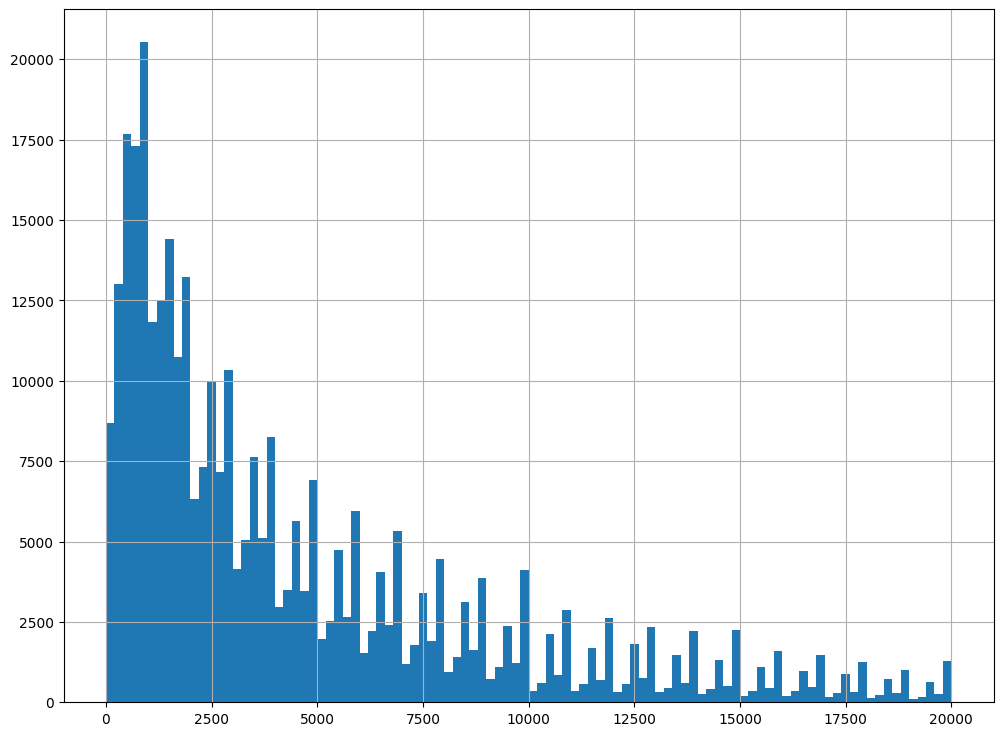

In [ ]:
filtred_autos_data = filtred_autos_data.query('Price > 0')
filtred_autos_data['Price'].hist(bins=100, figsize=(12,9))
filtred_autos_data['Price'].describe()

Выделим квантили 5% и 100%.

In [ ]:
filtred_autos_data['Price'].quantile([.05, 1])

0.05      350.0
1.00    20000.0
Name: Price, dtype: float64

Отсечем значения ближе 0 стоимотси. Установим за минимальную стоимость - стоимость авто 350 евро примерно равно 35000 рублей. Это минимальная цена для продажи поддержанного авто.

In [ ]:
filtred_autos_data = filtred_autos_data.query('350 <= Price <= 20000')
filtred_autos_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 328028 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   VehicleType       298829 non-null  object
 1   Gearbox           313649 non-null  object
 2   Power             328028 non-null  int64 
 3   Kilometer         328028 non-null  int64 
 4   FuelType          302806 non-null  object
 5   Brand             328028 non-null  object
 6   Repaired          269394 non-null  object
 7   RegistrationYear  328028 non-null  int64 
 8   Model             312393 non-null  object
 9   Price             328028 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 27.5+ MB


Проверим значения столбца RegistrationYear на гистограмме.

count    328028.000000
mean       2004.055721
std          67.546251
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: RegistrationYear, dtype: float64

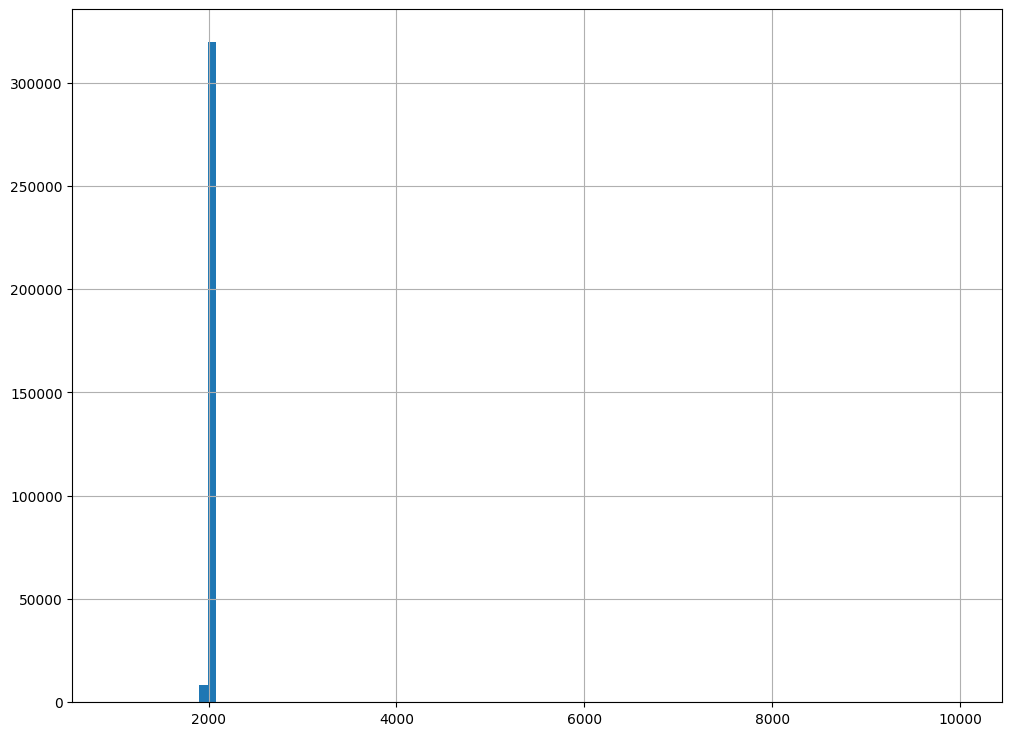

In [ ]:
filtred_autos_data['RegistrationYear'].hist(bins=100, figsize=(12,9))
filtred_autos_data['RegistrationYear'].describe()

В годе регистрации наблюдаются выбросы. Отсечем правые выбросы, узнав максимальную дату скачивания анкеты автомобиля.

In [ ]:
date = pd.to_datetime(autos_data['DateCrawled'])
date.max()

Timestamp('2016-04-07 14:36:58')

Даты регистрации после 2016 года некорректны и машины появились не раньше 1900 года. Отсечем ненужные года и промотрим левые выбросы.

count    314603.000000
mean       2002.783982
std           6.791094
min        1910.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2016.000000
Name: RegistrationYear, dtype: float64

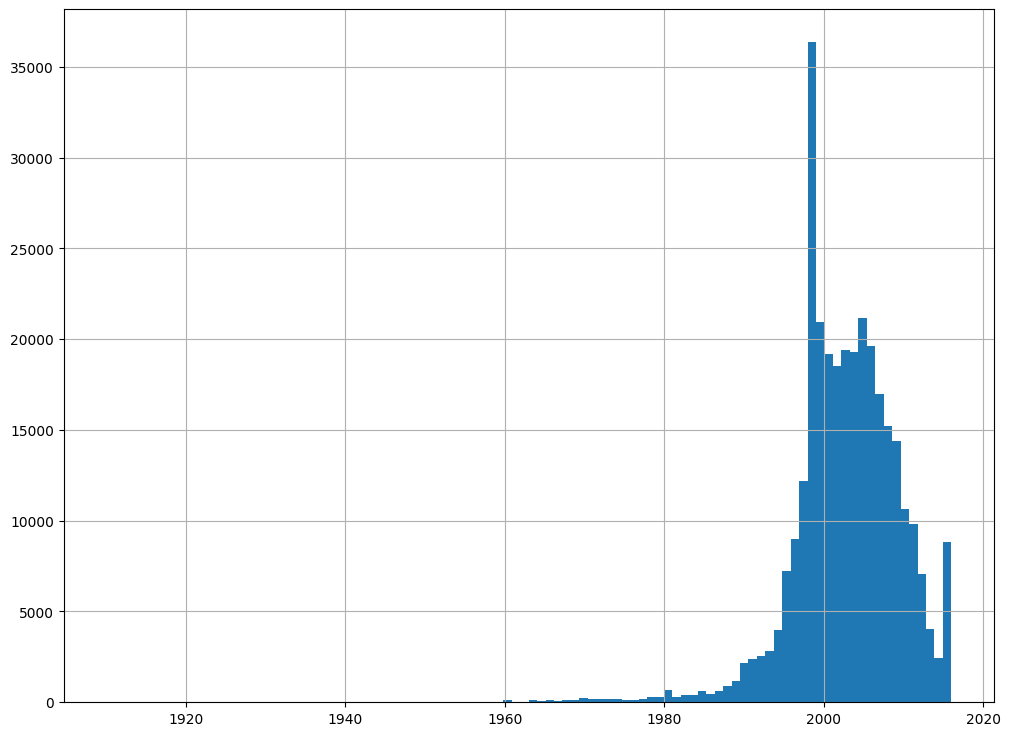

In [ ]:
filtred_autos_data = filtred_autos_data.query('1899 < RegistrationYear < 2017')
filtred_autos_data['RegistrationYear'].hist(bins=100, figsize=(12,9))
filtred_autos_data['RegistrationYear'].describe()

<div class="alert alert-success">
<b>ОТЛИЧНО! 👍</b>

Да, молодец, верно. Актуальность базы - 7 апреля 2016 год. Объявления после этой даты - ошибки. Раритеты - также нас не интересуют (у этих моделей цена совершенно не подчиняющаяся здравой логике).
</div>

По левой части гистограммы видно, что адекватно использовать левую границу в 1960 год, так как это старые, но возможно еще работающие машины.

count    314361.000000
mean       2002.827358
std           6.599397
min        1960.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2016.000000
Name: RegistrationYear, dtype: float64

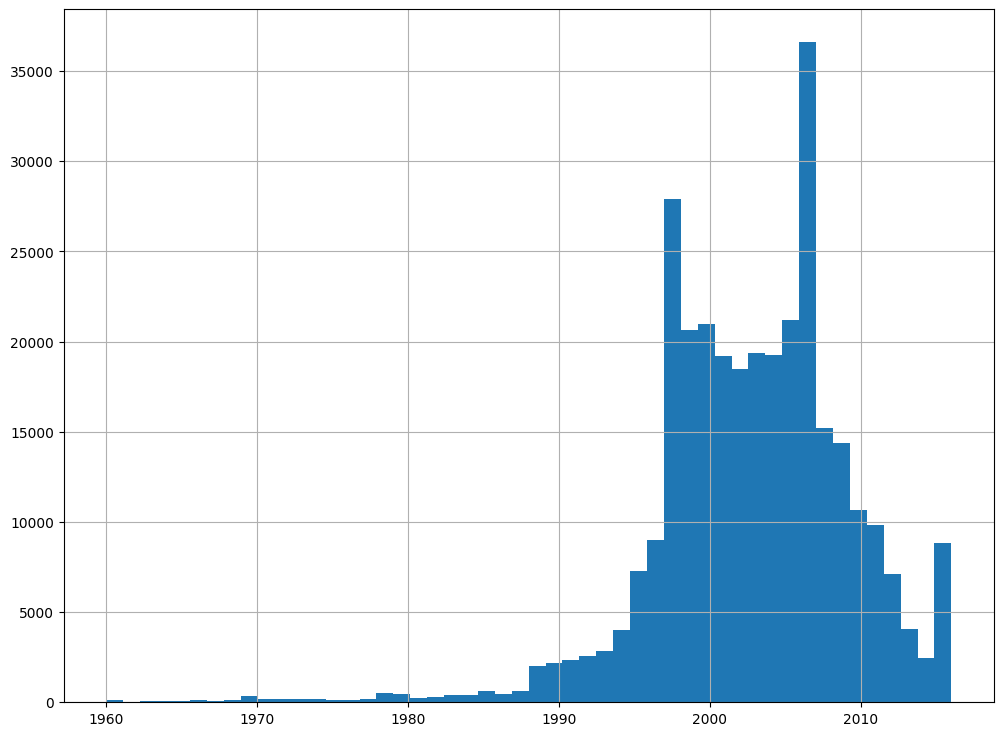

In [ ]:
filtred_autos_data = filtred_autos_data.query('1959 < RegistrationYear < 2017')
filtred_autos_data['RegistrationYear'].hist(bins=50, figsize=(12,9))
filtred_autos_data['RegistrationYear'].describe()

Проведем замену NaN в Gearbox, Repaired и Model.

In [ ]:
filtred_autos_data.fillna({'Gearbox':'manual',
                           'Repaired':'unknown',
                           'Model':'unknown'},
                          inplace=True)
filtred_autos_data.isna().mean()

VehicleType         0.050194
Gearbox             0.000000
Power               0.000000
Kilometer           0.000000
FuelType            0.063882
Brand               0.000000
Repaired            0.000000
RegistrationYear    0.000000
Model               0.000000
Price               0.000000
dtype: float64

In [ ]:
filtred_autos_data['Repaired'].unique()

array(['unknown', 'yes', 'no'], dtype=object)

Оценим количество пропущенных значений относительно всех значений в столбце VehicleType

In [ ]:
display(filtred_autos_data['VehicleType'].value_counts())
filtred_autos_data['VehicleType'].isna().sum()

sedan          87065
small          71968
wagon          62097
bus            28059
convertible    19674
coupe          15153
suv            11708
other           2858
Name: VehicleType, dtype: int64

15779

Выполним замену NaN в соотвествии с популярным типом кузова для каждого бренда.

In [ ]:
vehicle_type_pivot_table = filtred_autos_data.pivot_table(index=['VehicleType'],
                                                          columns=['Brand'],
                                                          values=['Price'],
                                                          aggfunc=['count'])
display(vehicle_type_pivot_table)
filtred_autos_data[filtred_autos_data['Brand'] == 'alfa_romeo']['VehicleType'].value_counts()

count                                                      \
                 Price                                                       
Brand       alfa_romeo     audi      bmw chevrolet chrysler citroen  dacia   
VehicleType                                                                  
bus                NaN     10.0      5.0     153.0    396.0  1242.0   50.0   
convertible      177.0   1609.0   3182.0      16.0    226.0   110.0    NaN   
coupe            225.0   1459.0   3595.0      88.0     46.0   141.0    NaN   
other             11.0    101.0    207.0      41.0      9.0   107.0    6.0   
sedan            866.0  10463.0  17025.0     220.0    263.0   652.0  100.0   
small            228.0   1515.0    400.0     578.0     12.0  1472.0  221.0   
suv                NaN    175.0    798.0     373.0     21.0    35.0  214.0   
wagon            441.0  10741.0   7678.0     105.0    240.0   589.0  250.0   

                                     ...                          \
                                     ...                           
Brand       daewoo daihatsu    fiat  ...    seat   skoda   smart   
VehicleType                          ...                           
bus           26.0     31.0   798.0  ...   610.0   229.0     1.0   
convertible    1.0     17.0   495.0  ...     NaN     4.0  1123.0   
coupe          2.0      NaN   164.0  ...    80.0     7.0   336.0   
other          5.0      9.0   170.0  ...    55.0    24.0     9.0   
sedan         87.0     41.0   822.0  ...  1676.0   888.0    27.0   
small        247.0    442.0  4756.0  ...  2902.0  1087.0  3220.0   
suv            1.0     46.0    24.0  ...     4.0   173.0     NaN   
wagon         36.0     16.0   390.0  ...   370.0  2672.0     9.0   

                                                                             
                                                                             
Brand       sonstige_autos subaru suzuki  toyota trabant volkswagen   volvo  
VehicleType                                                                  
bus                  180.0   17.0   27.0   446.0     NaN     9345.0     NaN  
convertible          311.0    1.0   33.0    63.0    36.0     2864.0    75.0  
coupe                214.0    8.0    6.0   213.0     2.0     1624.0    66.0  
other                191.0    5.0   12.0    18.0     5.0      679.0     5.0  
sedan                413.0  157.0  166.0   882.0   171.0    18909.0   616.0  
small                216.0  100.0  896.0  1569.0    49.0    16595.0     7.0  
suv                  410.0   58.0  741.0   436.0     1.0     1303.0   218.0  
wagon                120.0  276.0   84.0   568.0    66.0    12147.0  1866.0  

[8 rows x 40 columns]

sedan          866
wagon          441
small          228
coupe          225
convertible    177
other           11
Name: VehicleType, dtype: int64

In [ ]:
vehicle_type_pivot_table = vehicle_type_pivot_table['count']['Price']
vehicle_type_pivot_table

Brand,alfa_romeo,audi,bmw,chevrolet,chrysler,citroen,dacia,daewoo,daihatsu,fiat,...,seat,skoda,smart,sonstige_autos,subaru,suzuki,toyota,trabant,volkswagen,volvo
VehicleType,,,,,,,,,,,,,,,,,,,,,
bus,NaN,10.0,5.0,153.0,396.0,1242.0,50.0,26.0,31.0,798.0,...,610.0,229.0,1.0,180.0,17.0,27.0,446.0,NaN,9345.0,NaN
convertible,177.0,1609.0,3182.0,16.0,226.0,110.0,NaN,1.0,17.0,495.0,...,NaN,4.0,1123.0,311.0,1.0,33.0,63.0,36.0,2864.0,75.0
coupe,225.0,1459.0,3595.0,88.0,46.0,141.0,NaN,2.0,NaN,164.0,...,80.0,7.0,336.0,214.0,8.0,6.0,213.0,2.0,1624.0,66.0
other,11.0,101.0,207.0,41.0,9.0,107.0,6.0,5.0,9.0,170.0,...,55.0,24.0,9.0,191.0,5.0,12.0,18.0,5.0,679.0,5.0
sedan,866.0,10463.0,17025.0,220.0,263.0,652.0,100.0,87.0,41.0,822.0,...,1676.0,888.0,27.0,413.0,157.0,166.0,882.0,171.0,18909.0,616.0
small,228.0,1515.0,400.0,578.0,12.0,1472.0,221.0,247.0,442.0,4756.0,...,2902.0,1087.0,3220.0,216.0,100.0,896.0,1569.0,49.0,16595.0,7.0
suv,NaN,175.0,798.0,373.0,21.0,35.0,214.0,1.0,46.0,24.0,...,4.0,173.0,NaN,410.0,58.0,741.0,436.0,1.0,1303.0,218.0
wagon,441.0,10741.0,7678.0,105.0,240.0,589.0,250.0,36.0,16.0,390.0,...,370.0,2672.0,9.0,120.0,276.0,84.0,568.0,66.0,12147.0,1866.0


Заполним словарь брендов и популярных типов машин и заполним пропуски по столбцу VehicleType.

In [ ]:
filtred_autos_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 314361 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   VehicleType       298582 non-null  object
 1   Gearbox           314361 non-null  object
 2   Power             314361 non-null  int64 
 3   Kilometer         314361 non-null  int64 
 4   FuelType          294279 non-null  object
 5   Brand             314361 non-null  object
 6   Repaired          314361 non-null  object
 7   RegistrationYear  314361 non-null  int64 
 8   Model             314361 non-null  object
 9   Price             314361 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 26.4+ MB


In [ ]:
filtred_autos_data.fillna({'VehicleType':0},inplace=True)

def fillna_by_brand(row, row_number, vehicle_type_pivot_table):
    brand = row[5]
    fill_value = row[row_number]
    if row[row_number] == 0:
        fill_value = vehicle_type_pivot_table[brand].idxmax()
    return fill_value

filtred_autos_data['VehicleType'] = filtred_autos_data.apply(
                                fillna_by_brand,
                                args=[0, vehicle_type_pivot_table],
                                axis=1)
display(filtred_autos_data['VehicleType'].isna().sum())
filtred_autos_data['VehicleType'].value_counts()

0

sedan          94805
small          78403
wagon          63473
bus            28122
convertible    19703
coupe          15153
suv            11844
other           2858
Name: VehicleType, dtype: int64

Заполним пропуски в FuelType по похожему принципу.

In [ ]:
filtred_autos_data['FuelType'].value_counts()
fuel_type_pivot_table = filtred_autos_data.pivot_table(index=['FuelType'],
                                                          columns=['Brand'],
                                                          values=['Price'],
                                                          aggfunc=['count'])
fuel_type_pivot_table = fuel_type_pivot_table['count']['Price']
display(fuel_type_pivot_table)

filtred_autos_data.fillna({'FuelType':0},inplace=True)

filtred_autos_data['FuelType'] = filtred_autos_data.apply(
                                fillna_by_brand,
                                args=[4, vehicle_type_pivot_table],
                                axis=1)
display(filtred_autos_data['FuelType'].isna().sum())
filtred_autos_data['FuelType'].value_counts()

Brand,alfa_romeo,audi,bmw,chevrolet,chrysler,citroen,dacia,daewoo,daihatsu,fiat,...,seat,skoda,smart,sonstige_autos,subaru,suzuki,toyota,trabant,volkswagen,volvo
FuelType,,,,,,,,,,,,,,,,,,,,,
cng,NaN,1.0,8.0,4.0,NaN,7.0,2.0,NaN,NaN,65.0,...,2.0,6.0,2.0,7.0,2.0,NaN,NaN,NaN,174.0,20.0
electric,NaN,2.0,3.0,NaN,NaN,1.0,NaN,NaN,1.0,4.0,...,NaN,NaN,7.0,21.0,NaN,NaN,NaN,NaN,1.0,NaN
gasoline,577.0,11981.0,11741.0,234.0,361.0,1523.0,204.0,1.0,4.0,1386.0,...,1595.0,1889.0,841.0,423.0,41.0,226.0,963.0,1.0,24357.0,1030.0
hybrid,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,...,1.0,NaN,1.0,19.0,NaN,NaN,125.0,NaN,5.0,NaN
lpg,31.0,435.0,720.0,175.0,93.0,63.0,52.0,23.0,5.0,64.0,...,60.0,51.0,3.0,121.0,29.0,22.0,25.0,NaN,506.0,105.0
other,NaN,3.0,6.0,1.0,NaN,2.0,NaN,1.0,NaN,3.0,...,NaN,NaN,1.0,18.0,NaN,1.0,NaN,32.0,16.0,2.0
petrol,1323.0,13275.0,19690.0,1124.0,738.0,2713.0,561.0,374.0,582.0,5995.0,...,4006.0,3065.0,3837.0,1332.0,532.0,1686.0,3058.0,249.0,38030.0,1639.0


0

petrol         194151
gasoline        94230
sedan            9539
small            8309
lpg              4949
wagon            1922
cng               519
hybrid            218
suv               185
other             129
bus                84
electric           83
convertible        43
Name: FuelType, dtype: int64

In [ ]:
filtred_autos_data.isna().mean()

VehicleType         0.0
Gearbox             0.0
Power               0.0
Kilometer           0.0
FuelType            0.0
Brand               0.0
Repaired            0.0
RegistrationYear    0.0
Model               0.0
Price               0.0
dtype: float64

Пропуски убраны. Осталось заняться некорректнымми значениями в столбце Power.

count    314361.000000
mean        114.570799
std         185.324543
min           0.000000
25%          75.000000
50%         107.000000
75%         144.000000
max       20000.000000
Name: Power, dtype: float64

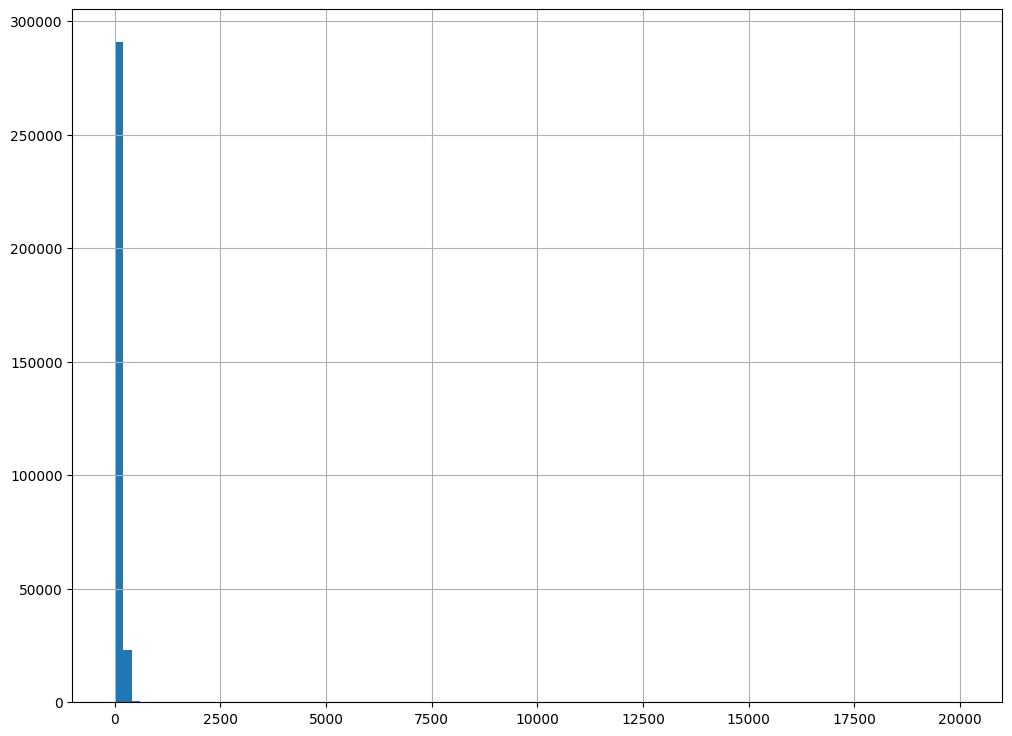

In [ ]:
filtred_autos_data['Power'].hist(bins=100, figsize=(12,9))
filtred_autos_data['Power'].describe()

Раброс очень сильный, усечем выбросы больше 1000 л.с.

count    314117.000000
mean        111.376121
std          62.603099
min           0.000000
25%          75.000000
50%         106.000000
75%         144.000000
max        1000.000000
Name: Power, dtype: float64

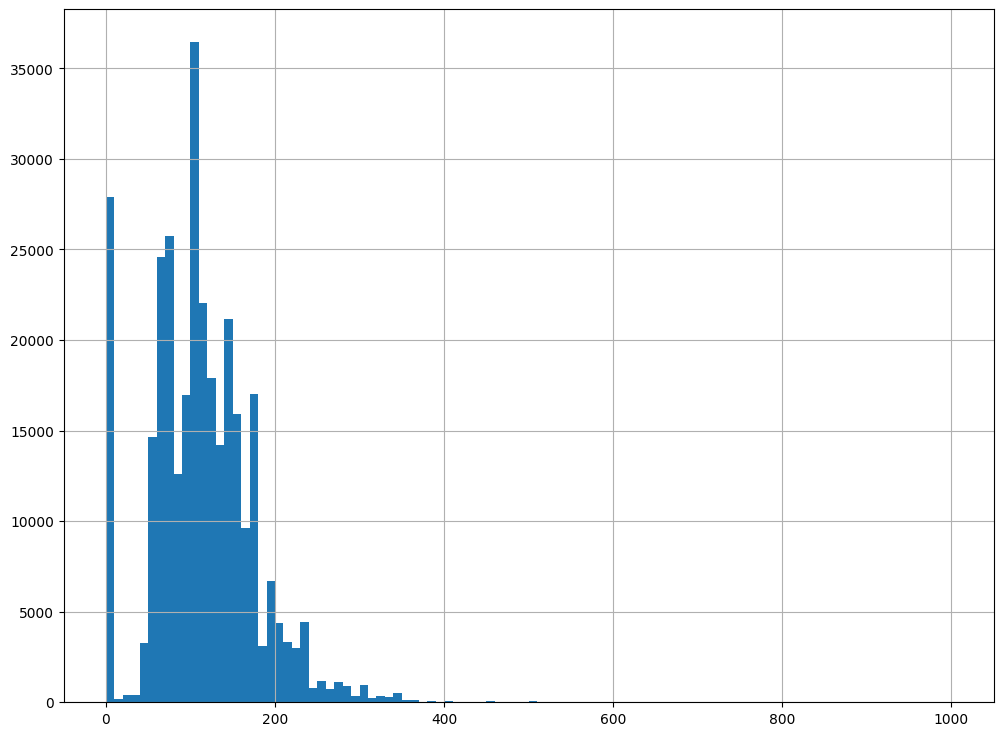

In [ ]:
filtred_autos_data = filtred_autos_data.query('Power < 1001')
filtred_autos_data['Power'].hist(bins=100, figsize=(12,9))
filtred_autos_data['Power'].describe()

Из графика видно, что многие машины имеют мощность 0. Эти строки не подлежат восстановлению и будут удалены. По правому отсечению выбреме границу в 400 л.с.

count    286056.000000
mean        121.628555
std          52.598098
min           1.000000
25%          80.000000
50%         115.000000
75%         150.000000
max         400.000000
Name: Power, dtype: float64

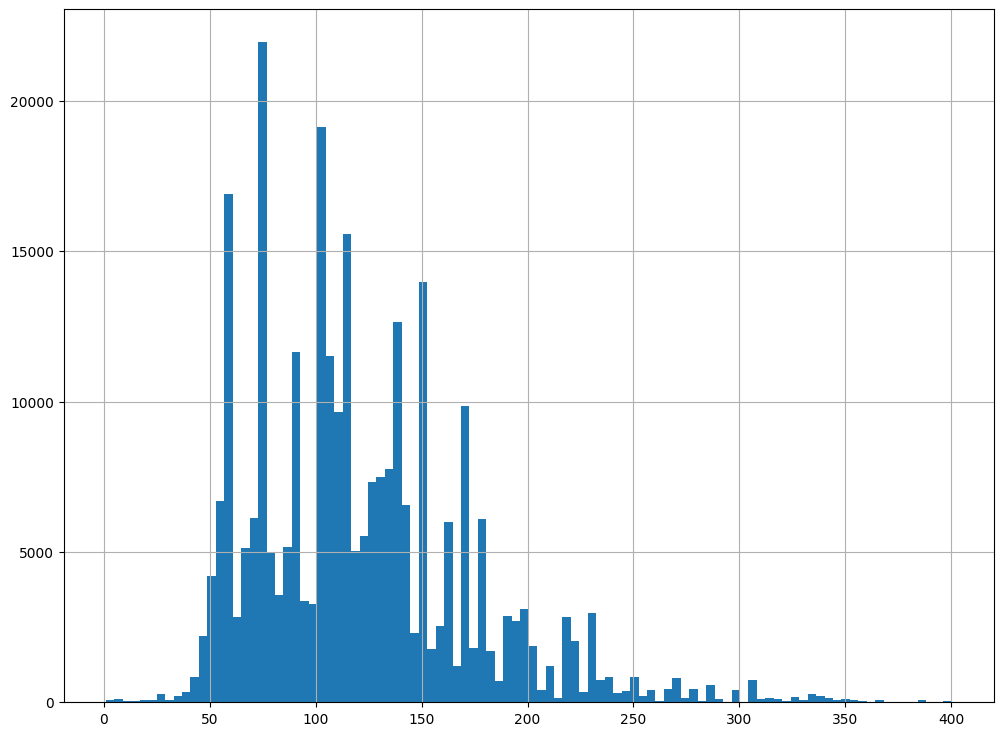

In [ ]:
filtred_autos_data = filtred_autos_data.query('0 < Power < 401')
filtred_autos_data['Power'].hist(bins=100, figsize=(12,9))
filtred_autos_data['Power'].describe()

Следующими границами выберем 25 и 350 л.с.

count    285179.000000
mean        121.404956
std          51.550854
min          25.000000
25%          80.000000
50%         115.000000
75%         150.000000
max         350.000000
Name: Power, dtype: float64

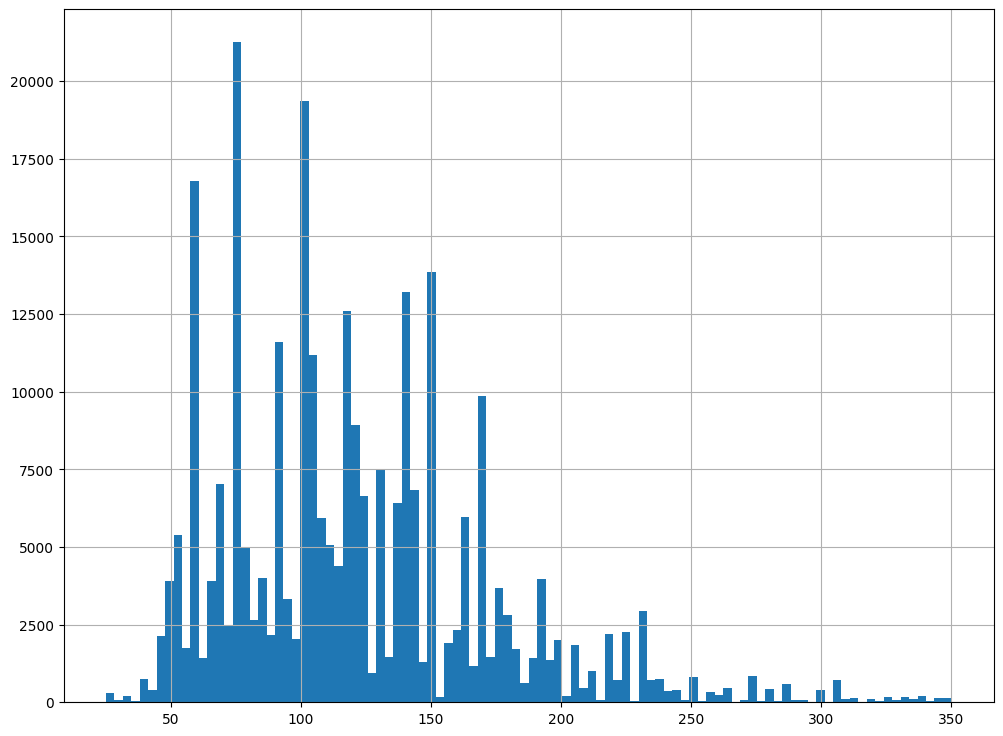

In [ ]:
good_autos_data = filtred_autos_data.query('24 < Power < 351')
good_autos_data['Power'].hist(bins=100, figsize=(12,9))
good_autos_data['Power'].describe()

In [ ]:
good_autos_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 285179 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   VehicleType       285179 non-null  object
 1   Gearbox           285179 non-null  object
 2   Power             285179 non-null  int64 
 3   Kilometer         285179 non-null  int64 
 4   FuelType          285179 non-null  object
 5   Brand             285179 non-null  object
 6   Repaired          285179 non-null  object
 7   RegistrationYear  285179 non-null  int64 
 8   Model             285179 non-null  object
 9   Price             285179 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 23.9+ MB


Проведем замену столбцов Gearbox и NotRepaired на булев тип.

- IsManualGearbox. 1(manual) - означает механическую коробку передач. 0(auto) - автоматическую.
- IsNotRepaired. 1(yes) - означает машину без ремонта. 0(no) - с ремонтом.

In [ ]:
good_autos_data['IsManualGearbox'] = 0
good_autos_data.loc[good_autos_data['Gearbox'] == 'manual', 'IsManualGearbox'] = 1
display(good_autos_data['IsManualGearbox'].value_counts())
good_autos_data['Gearbox'].value_counts()

<ipython-input-30-ca14879b377f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  good_autos_data['IsManualGearbox'] = 0


1    227656
0     57523
Name: IsManualGearbox, dtype: int64

manual    227656
auto       57523
Name: Gearbox, dtype: int64

In [ ]:
good_autos_data['IsRepaired'] = 0
good_autos_data.loc[good_autos_data['Repaired'] == 'yes', 'IsRepaired'] = 1
display(good_autos_data['IsRepaired'].value_counts())
good_autos_data['Repaired'].value_counts()

<ipython-input-31-3bae79ac04a7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  good_autos_data['IsRepaired'] = 0


0    260097
1     25082
Name: IsRepaired, dtype: int64

no         221006
unknown     39091
yes         25082
Name: Repaired, dtype: int64

Удалим ненужные столбцы и уменьшим размерность хранения типа для ускорения работы с дата фреймом.

In [ ]:
good_autos_data.drop(['Repaired','Gearbox'], inplace=True, axis=1)
good_autos_data['IsRepaired'] = pd.to_numeric(good_autos_data['IsRepaired'], downcast='integer')
good_autos_data['IsManualGearbox'] = pd.to_numeric(good_autos_data['IsManualGearbox'], downcast='integer')
good_autos_data['RegistrationYear'] = pd.to_numeric(good_autos_data['RegistrationYear'], downcast='integer')
good_autos_data['Power'] = pd.to_numeric(good_autos_data['Power'], downcast='integer')
good_autos_data['Kilometer'] = pd.to_numeric(good_autos_data['Kilometer'], downcast='integer')
good_autos_data['Price'] = pd.to_numeric(good_autos_data['Price'], downcast='integer')
good_autos_data.info()

<ipython-input-32-c19751b9669a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  good_autos_data.drop(['Repaired','Gearbox'], inplace=True, axis=1)
<ipython-input-32-c19751b9669a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  good_autos_data['IsRepaired'] = pd.to_numeric(good_autos_data['IsRepaired'], downcast='integer')
<ipython-input-32-c19751b9669a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

<class 'pandas.core.frame.DataFrame'>
Int64Index: 285179 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   VehicleType       285179 non-null  object
 1   Power             285179 non-null  int16 
 2   Kilometer         285179 non-null  int32 
 3   FuelType          285179 non-null  object
 4   Brand             285179 non-null  object
 5   RegistrationYear  285179 non-null  int16 
 6   Model             285179 non-null  object
 7   Price             285179 non-null  int16 
 8   IsManualGearbox   285179 non-null  int8  
 9   IsRepaired        285179 non-null  int8  
dtypes: int16(3), int32(1), int8(2), object(4)
memory usage: 14.1+ MB


In [ ]:
print('Уменьшение использования памяти на {:.2%}'.format(1 - 10.7/43.3))

Уменьшение использования памяти на 75.29%


### Вывод по шагу 1.

1. Была изучена таблица данных.
2. Выведены аномальные и пропущенные значения.
3. Отобраны небходимые столбцы для обучения модели.
4. Заполнены пропуски в столбцах и удалены некорректные значения.
5. Заменены два категориальных признака на численные.
6. Выигрыш в памяти составляет 75%, что ускорит обращение к памяти при обучении модели.

## Обучение моделей

Выберем следующие регрессоры для обучения модели:

1. LinearRegression
2. DecisionTreeRegressor
3. CatBoostRegressor
4. LGBMRegressor

В качестве метрики для всех моделей будем использовать MSE и в финальной таблице переведем в RMSE. Качество моделей будем проверять на кроссвалидации.

# Разделим выборки

In [ ]:
#выделяю признаки и целевой признак:
features_orig = good_autos_data.drop(['Price'], axis = 1) #извлекаю признак
target = good_autos_data['Price'] #целевой признак

In [ ]:
#разделяю на выборки:
features_train, features_test, target_train, target_test = train_test_split(features_orig,
                                                                            target,
                                                                            test_size=.25,
                                                                            random_state=12345)

In [ ]:
!pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 1.5 MB/s eta 0:00:00


In [ ]:
from sklearn.preprocessing import OneHotEncoder
from category_encoders.m_estimate import MEstimateEncoder



#кодирую признаки через OHE:
endcoder_1 = OneHotEncoder()
endcoder_2 = MEstimateEncoder()

endcoder_1.fit(features_orig[['VehicleType','FuelType']])
endcoder_2.fit(features_orig[['Model','Brand']], y=target)

features_train_oh = endcoder_1.transform(features_train[['VehicleType','FuelType']])
features_train_m = endcoder_2.transform(X=features_train[['Model','Brand']])

features_test_oh = endcoder_1.transform(features_test[['VehicleType','FuelType']])
features_test_m = endcoder_2.transform(X=features_test[['Model','Brand']])

features_train_cat = pd.concat([pd.DataFrame.sparse.from_spmatrix(features_train_oh).reset_index(), features_train_m.reset_index()], ignore_index = True, axis=1)
features_test_cat = pd.concat([pd.DataFrame.sparse.from_spmatrix(features_test_oh).reset_index(), features_test_m.reset_index()], ignore_index = True, axis=1)


In [ ]:
#смотрю размеры выборок:
for i in [features_train_cat, features_test_cat, target_train, target_test]:
    print(i.shape)

print()

for i in [features_train, features_test, target_train, target_test]:
    print(i.shape)

(213884, 25)
(71295, 25)
(213884,)
(71295,)

(213884, 9)
(71295, 9)
(213884,)
(71295,)


### Модель LinearRegression

#### На выборках c OneHotEncoder


In [ ]:
scaler = StandardScaler()

scaler.fit(features_orig[['Power', 'Kilometer', 'RegistrationYear']])

features_train_numeric = pd.DataFrame(scaler.transform(features_train[['Power', 'Kilometer', 'RegistrationYear']]))
features_test_numeric = pd.DataFrame(scaler.transform(features_test[['Power', 'Kilometer', 'RegistrationYear']]))

features_train_con = pd.concat([features_train_numeric.reset_index(), features_train_cat.reset_index()], ignore_index = True, axis=1)
features_test_con = pd.concat([features_test_numeric.reset_index(), features_test_cat.reset_index()], ignore_index = True, axis=1)

In [ ]:
start_time = time.time()

model_lr = LinearRegression()
model_lr.fit(features_train_con, target_train)

end_time = time.time()

training_time_lr = end_time - start_time

print("Время обучения LinearRegression OHE: %s секунд" % training_time_lr)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


Время обучения LinearRegression OHE: 1.3285627365112305 секунд


In [ ]:
start_time_predict = time.time()

target_predict = model_lr.predict(features_test_con)

end_time_predict = time.time()

prediction_time_lr = end_time_predict - start_time_predict

rmse_lr = mean_squared_error(target_test, target_predict) ** .5
rmse_lr

print("RMSE LinearRegression OHE: %.2f" % rmse_lr)

RMSE LinearRegression OHE: 2771.89


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


#### C использованием кроссвалидации

In [ ]:
%%time
from sklearn.model_selection import cross_validate

model_lr = LinearRegression()

#mse доступна только как neg_mean_squared_error, которая возвращает массив отрицательных значений
#поэтому на -1 умножаю:

dataset_full = pd.concat([features_train_con.reset_index(), features_test_con.reset_index()], ignore_index=True).to_numpy()
history = cross_validate(model_lr,dataset_full,target.to_numpy(),cv=5, scoring="neg_mean_squared_error")
(history['test_score'].mean()*-1)**0.5

CPU times: user 3.51 s, sys: 1.75 s, total: 5.25 s
Wall time: 6.56 s


4593.536699111464

### Модель CatBoostRegressor

#### На выборках c OneHotEncoder

In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 2.5 MB/s eta 0:00:00


In [ ]:
%%time
from catboost import CatBoostRegressor

model_cbr = CatBoostRegressor()
parameters = [{'learning_rate':[.001, .05], 'random_state':[12345], 'verbose':[False]}]

gscv = GridSearchCV(model_cbr, parameters, scoring='neg_mean_squared_error')
gscv.fit(pd.concat([pd.concat([features_train_numeric.reset_index(), features_test_numeric.reset_index()], ignore_index=True).reset_index(), pd.concat([features_train_cat.reset_index(), features_test_cat.reset_index()], ignore_index=True).reset_index()], ignore_index=True, axis=1), target)

print(gscv.best_params_)

mts = gscv.cv_results_['mean_test_score']

gscv_rsme_cbr = (max(mts) * -1) ** .5
gscv_rsme_cbr

{'learning_rate': 0.001, 'random_state': 12345, 'verbose': False}
CPU times: user 12min 19s, sys: 16.2 s, total: 12min 36s
Wall time: 8min 1s


4585.900311939791

In [ ]:
start_time = time.time()

model_cbr = CatBoostRegressor(learning_rate=.001, random_state=12345, verbose=False) #подставил лучшие параметры
model_cbr.fit(features_train_con, target_train)

end_time = time.time()
training_time_cbr = end_time - start_time

# Время обучения модели CatBoostRegressor
print("Время обучения CatBoostRegressor: %s секунд" % training_time_cbr)

Время обучения CatBoostRegressor: 38.76447868347168 секунд


In [ ]:
start_time = time.time()

model_cbr.fit(features_train_con, target_train)
target_predict = model_cbr.predict(features_train_con)

end_time = time.time()
prediction_time_cbr = end_time - start_time

# Время предсказания модели CatBoostRegressor
print("Время обучения CatBoostRegressor: %s секунд" % prediction_time_cbr)

Время обучения CatBoostRegressor: 39.22766661643982 секунд


In [ ]:
# Оценка качества модели CatBoostRegressor
rmse_cbr = mean_squared_error(target_train, target_predict) ** .5
rmse_cbr

print("RMSE CatBoostRegressor OHE: %.2f" % rmse_cbr)

RMSE CatBoostRegressor OHE: 2762.03


#### На выборках без кодировки

In [ ]:
start_time = time.time()

model_cbr_ncd = CatBoostRegressor(learning_rate=.5, iterations=200, random_state=12345, verbose=False,
                              cat_features=['VehicleType','FuelType','Brand','Model'])

model_cbr_ncd.fit(features_train, target_train)

end_time = time.time()
training_time_cbr_ncd = end_time - start_time

# Время обучения модели CatBoostRegressor Without
print("Время обучения CatBoostRegressor Without: %s секунд" % training_time_cbr_ncd)

Время обучения CatBoostRegressor Without: 39.0954647064209 секунд


In [ ]:
start_time = time.time()

target_predict = model_cbr.predict(features_test_con)

end_time = time.time()
prediction_time_cbr_ncd = end_time - start_time

# Время предсказания модели CatBoostRegressor without
print("Время обучения CatBoostRegressor Without: %s секунд" % prediction_time_cbr_ncd)

Время обучения CatBoostRegressor Without: 0.08074808120727539 секунд


In [ ]:
# Оценка качества модели CatBoostRegressor without
rmse_cbr_ncd = mean_squared_error(target_test, target_predict) ** .5
rmse_cbr_ncd
print("RMSE CatBoostRegressor WT: %.2f" % rmse_cbr_ncd)

RMSE CatBoostRegressor WT: 2766.62


### Модель LightGBMRegressor

#### На выборках c OneHotEncoder

In [ ]:
%%time

model_lgbmr = LGBMRegressor()
parameters = [{'num_leaves':[25, 50, 100, 200], 'learning_rate':[.001, .03], 'random_state':[12345]}]

clf = GridSearchCV(model_lgbmr, parameters, scoring='neg_mean_squared_error')
clf.fit(features_train_con, target_train)

print(clf.best_params_)
print()

mts = clf.cv_results_['mean_test_score']

rsme_lgbmr = (max(mts) * -1) ** .5
rsme_lgbmr

{'learning_rate': 0.03, 'num_leaves': 200, 'random_state': 12345}

CPU times: user 4min 5s, sys: 2.78 s, total: 4min 8s
Wall time: 2min 41s


1698.4686164195798

In [ ]:
start_time = time.time()

model_lgbmr = LGBMRegressor(learning_rate=.3, num_leaves=200, random_state=12345)
model_lgbmr.fit(features_train_con, target_train)

end_time = time.time()
training_time_lgbmr = end_time - start_time

# Время обучения модели lgbmr OHE
print("Время обучения lgbmr OHE: %s секунд" % training_time_lgbmr)

Время обучения lgbmr OHE: 2.4601948261260986 секунд


In [ ]:
start_time = time.time()

target_predict = model_lgbmr.predict(features_test_con)

end_time = time.time()
prediction_time_lgbmr = end_time - start_time

# Время предсказания модели lgbmr
print("Время предсказания lgbmr: %s секунд" % prediction_time_lgbmr)

Время предсказания lgbmr: 0.40732479095458984 секунд


In [ ]:
# Оценка качества модели lgbmr
rsme_lgbmr = mean_squared_error(target_test, target_predict) ** .5
rsme_lgbmr
print("RMSE lgbmr: %.2f" % rsme_lgbmr)

RMSE lgbmr: 1639.92


### Выводы:
1. Обучил 3 модели - линейную регрессию, CatBoostRegressor и LGBMRegressor - со сменой гиперпараметров и на разных выборках - изначальные, с обычной кодировкой и OHE.
2. Часть моделей дали RMSE > 2500, поэтому финальный вывод буду делать только на моделях, которые дали RMSE < 2500

## Выбор лучшей модели и ее тестирование

In [ ]:
#создаю сводную таблицу по показателям RMSE < 2500, время обучения модели и время предсказания модели:
index = ['Линейная регрессия',
         'CatBoostRegressor',
         'CatBoostRegressor без кодировки',
         'LGBMRegressor',
        ]

data = {'RMSE':[rmse_lr,
                rmse_cbr,
                rmse_cbr_ncd,
                rsme_lgbmr],

        'Время обучения модели':[training_time_lr,
                                 training_time_cbr,
                                 training_time_cbr_ncd,
                                 training_time_lgbmr],

        'Время предсказания модели':[prediction_time_lr,
                                     prediction_time_cbr,
                                     prediction_time_cbr_ncd,
                                     prediction_time_lgbmr]
       }

kpi_data = pd.DataFrame(data=data, index=index)

#ввожу столбец Рейтинг с весами:
kpi_data['Рейтинг'] = (kpi_data['RMSE'] * .34 \
                       + kpi_data['Время обучения модели'] * .33 \
                       + kpi_data['Время предсказания модели'] * .33)

kpi_data.sort_values(by = 'Рейтинг', ascending=True)

,RMSE,Время обучения модели,Время предсказания модели,Рейтинг
LGBMRegressor,1639.922072,2.460195,0.407325,558.519786
Линейная регрессия,2771.891920,1.328563,0.059314,942.901252
CatBoostRegressor без кодировки,2766.615046,39.095465,0.080748,953.577266
CatBoostRegressor,2762.034572,38.764479,39.227667,964.829162


Промежуточный вывод:

Лучшей моделью по RMSE, времени обучения модели, времени предсказания модели, если считать эти параметры одинаково важными для принятия решения, является LGBMRegressor с выборками c OHE.
Аутсайдер рейтинга - модель CatBoostRegressor.

In [ ]:
features_ohe = pd.concat([features_test_cat.reset_index(), features_train_cat.reset_index()], ignore_index=True)

In [ ]:
#смотрю размеры получившихся выборок:
for i in [features_train_ohe, features_valid_ohe, features_test_ohe, target_train_ohe, target_valid_ohe, target_test_ohe]:
    print(i.shape)

NameError: ignored

In [ ]:
%%time

model_lgbmr = LGBMRegressor(learning_rate=.03, num_leaves=200, random_state=12345)
model_lgbmr.fit(features_train_ohe, target_train_ohe)

In [ ]:
%%time

target_predict_ohe = model_lgbmr.predict(features_valid_ohe)

CPU times: user 525 ms, sys: 900 µs, total: 526 ms
Wall time: 287 ms


In [ ]:
rsme_lgbmr_ohe = mean_squared_error(target_valid_ohe, target_predict_ohe) ** .5
rsme_lgbmr_ohe

4593.877901788923

In [ ]:
%%time

#проверяю качество модели на тестовой выборке:
model_lgbmr = LGBMRegressor(learning_rate=.03, num_leaves=200, random_state=12345)
model_lgbmr.fit(features_train_ohe, target_train_ohe)

CPU times: user 7.95 s, sys: 64.9 ms, total: 8.02 s
Wall time: 8.75 s


LGBMRegressor(learning_rate=0.03, num_leaves=200, random_state=12345)

In [ ]:
%%time

target_predict_ohe = model_lgbmr.predict(features_test_ohe)

CPU times: user 523 ms, sys: 0 ns, total: 523 ms
Wall time: 278 ms


In [ ]:
final_rsme_lgbmr_ohe = mean_squared_error(target_test_ohe, target_predict_ohe) ** .5
final_rsme_lgbmr_ohe

4611.421556453172

In [ ]:
#добавляю в сравнительную таблицу финальные данные:
kpi_data.loc['Финальные данные на лучшей модели'] = [final_rsme_lgbmr_ohe, 9.34, 1.5, final_rsme_lgbmr_ohe * .34 + 10.1 * .33 + 1.57 * .33]
kpi_data.sort_values(by = 'Рейтинг', ascending=True)

,RMSE,Время обучения модели,Время предсказания модели,Рейтинг
LGBMRegressor,1639.922072,2.485982,1.176027,558.781968
Линейная регрессия,2771.891920,0.696456,0.019191,942.679416
CatBoostRegressor без кодировки,2766.615046,38.285247,0.077595,953.308854
CatBoostRegressor,2766.615046,42.498507,0.192667,954.737203
Финальные данные на лучшей модели,4611.421556,9.340000,1.500000,1571.734429


Промежуточный вывод: финальная проверка на лучшей модели - LGBMRegressor с выборками c OHE - дала RMSE 1302, общее место в рейтинге - 1.

<div style="border:2px solid Black; padding:20px;">

## Вывод

В проекте:
- загрузил  данные и провел их предобработку - очистку, заполнение, удаление лишних данных
- сравнил 3 модели с разными гиперпараметрами и выборками
- выбрал лучшую модель по 3 показателям - RMSE, время обучения и время предскзания - и проверила ее на тестовой выборке

Итог - наилучшей моделью стала LGBMRegressor с OHE, которая на финальном тестировании показала RMSE 1302, несмотря на требуемое бОльшее время на обучение и предсказание. То есть если есть время, то лучше пользоваться данной моделью

</div>